#Imports

In [ ]:
# !CFLAGS="-Wno-narrowing" pip install cld2-cffi #uncomment to install cld2

In [59]:
import pandas as pd 
import numpy as np
from numpy.random import randint
import seaborn as sns
from collections import Counter, OrderedDict
import cld2

# import utils functions and classes
from DataLoader import TADataLoader
from TextPreprocessing import TextPreprocessor, LemmatizeCorpus
from TextPreprocessing import stem_corpus
from Deliverable3 import Embeddor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

import gensim.downloader as api

import nltk
nltk.download('punkt')
nltk.download('stopwords')


import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 6)
sns.set_palette("husl")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#Loading the data

In [ ]:
loader = TADataLoader()
df_restos, df_reviews = loader.load_restos(drop_duplicates=True), loader.load_reviews(drop_duplicates=True)
df_reviews = df_reviews.iloc[:5000]
preprocessor = TextPreprocessor(df_reviews, column_to_clean='review_content')
preprocessor.transform(n_grams=False)
corpus = preprocessor.corpus

#LSI

We first perform LSI with respect to the reviews on the the two first dimensions

In [186]:
embeddor = Embeddor(corpus=corpus)
embeddor.transform(vec_method="tfidf", how="SVD", n=2)
lsi = embeddor.review_embedding
lsi['corpus'] = corpus
lsi['rating'] = df_reviews['review_rating']
lsi.head()

,SV1,SV2,corpus,rating
0,0.037762,-0.036615,"[booked, mezzet, dar, realising, two, differen...",5
1,0.155685,-0.059344,"[awesome, thai, worked, hard, lockdown, delive...",5
2,0.089527,-0.010709,"[staff, kind, charming, food, always, delivers...",4
3,0.243792,0.145052,"[awesome, experience, amazing, food, high, qua...",5
4,0.198572,-0.151046,"[every, time, visit, restaurant, never, disapp...",5


Now, we compute LSI with as many dimensions as needed to explain a given percentage of the variance. 

In [187]:
embeddor = Embeddor(corpus=corpus)
embeddor.transform(vec_method="tfidf", how="SVD", n="n_opt", threshold=0.5)
lsi = embeddor.review_embedding
lsi['corpus'] = corpus
lsi['rating'] = df_reviews['review_rating']
lsi.head()

330


,SV1,SV2,SV3,SV4,SV5,SV6,SV7,SV8,SV9,SV10,SV11,SV12,SV13,SV14,SV15,SV16,SV17,SV18,SV19,SV20,SV21,SV22,SV23,SV24,SV25,SV26,SV27,SV28,SV29,SV30,SV31,SV32,SV33,SV34,SV35,SV36,SV37,SV38,SV39,SV40,...,SV293,SV294,SV295,SV296,SV297,SV298,SV299,SV300,SV301,SV302,SV303,SV304,SV305,SV306,SV307,SV308,SV309,SV310,SV311,SV312,SV313,SV314,SV315,SV316,SV317,SV318,SV319,SV320,SV321,SV322,SV323,SV324,SV325,SV326,SV327,SV328,SV329,SV330,corpus,rating
0,0.037762,-0.038408,-0.028882,-0.020539,0.033934,-0.029760,-0.028694,-0.011273,-0.007795,0.010161,-0.005978,0.016179,-0.014407,-0.046543,-0.023651,-0.032635,-0.047314,0.015541,0.025148,0.016064,0.033407,-0.044499,-0.052222,-0.052762,0.037424,-0.058029,-0.047805,-0.045288,-0.003788,-0.021665,-0.052454,-0.043019,-0.033812,0.020609,0.020312,0.027113,-0.012562,-0.000944,-0.050240,0.010649,...,-0.009865,0.013547,-0.005341,0.014743,-0.025906,-0.026349,0.011476,0.020437,-0.011178,0.008645,-0.013624,0.028849,-0.017839,-0.005073,0.008498,-0.014506,-0.029478,0.010890,-0.004532,0.015505,-0.010265,-0.010081,0.002429,-0.003077,-0.010493,-0.022688,0.007993,-0.016593,0.031353,0.023908,-0.011933,0.018990,0.000535,-0.011655,0.019294,0.014786,0.026062,-0.004558,"[booked, mezzet, dar, realising, two, differen...",5
1,0.155684,-0.060575,-0.002849,0.050418,0.061794,-0.022166,-0.028149,-0.063383,0.015958,0.018195,0.007241,-0.030290,-0.033083,0.042874,-0.075166,0.001396,0.047377,0.045367,-0.005225,-0.038570,-0.013724,-0.038513,-0.022012,0.035494,-0.011560,-0.029909,0.016781,-0.014552,0.003315,-0.033400,0.004138,0.018322,-0.027349,-0.012866,-0.021100,-0.015494,0.039709,-0.028089,-0.000756,-0.023296,...,-0.009821,-0.038590,-0.033906,-0.054263,0.002236,0.001972,0.036284,0.035681,-0.015265,0.015018,-0.022413,0.003877,-0.007044,-0.057134,-0.007136,-0.031925,-0.045036,-0.006756,0.030152,-0.019732,0.030774,0.008517,0.031870,0.015895,-0.045538,-0.020747,-0.019125,0.017044,0.015127,0.030119,0.032218,-0.004049,-0.021447,-0.009741,0.044166,0.017927,-0.012479,-0.023228,"[awesome, thai, worked, hard, lockdown, delive...",5
2,0.089527,-0.013455,-0.013768,0.013359,-0.036510,0.006571,0.029306,-0.021307,-0.017234,-0.009694,-0.021002,-0.002503,-0.013465,-0.025043,-0.006816,-0.006213,-0.004508,-0.017730,-0.009788,-0.064183,0.023817,0.013942,-0.022569,-0.000412,0.012953,0.025054,0.024041,-0.009799,0.002709,0.000824,0.040005,0.006925,0.007848,-0.009751,0.001639,-0.014669,0.030440,0.014639,-0.038576,0.002960,...,0.000573,-0.014723,-0.002161,0.003057,0.042291,-0.003780,0.009903,-0.022087,-0.004641,-0.031727,-0.021559,0.015413,0.003000,-0.029170,0.032162,-0.003985,0.016561,-0.073101,0.037548,0.009622,-0.027878,0.037764,0.019694,-0.019835,-0.022645,-0.003096,-0.057177,-0.052574,-0.035685,-0.030644,-0.023539,-0.002613,-0.042545,0.005329,-0.030196,0.002806,-0.043169,-0.004686,"[staff, kind, charming, food, always, delivers...",4
3,0.243794,0.146270,0.081960,-0.022791,0.171777,0.027331,0.121617,0.087025,-0.130206,-0.049666,0.007702,0.055521,0.043711,-0.036673,-0.073936,-0.059960,0.043857,-0.047125,0.037230,-0.038214,0.117461,0.062878,-0.020902,-0.032352,0.039251,-0.011851,0.098889,-0.065050,-0.097792,0.066540,0.109178,0.106842,0.076124,0.072679,0.019619,0.089883,0.198060,-0.139723,-0.043368,0.024889,...,-0.027385,0.072144,0.017161,-0.029941,-0.011568,-0.011057,-0.004531,-0.030408,0.014323,-0.041187,0.005229,0.050859,0.061136,-0.015756,-0.030991,0.006695,-0.042875,-0.008224,0.028455,0.091291,-0.029217,-0.010925,0.025413,-0.002638,-0.021490,-0.003954,0.014066,-0.037533,-0.020878,0.035578,-0.031220,-0.022310,-0.039291,0.010851,0.027783,-0.016941,0.011120,-0.005231,"[awesome, experience, amazing, food, high, qua...",5
4,0.198566,-0.175192,-0.104202,-0.126077,0.101698,0.006643,-0.136440,-0.154993,-0.118142,-0.084543,0.098234,0.277969,0.090922,-0.062838,-0.006737,0.278020,0.197366,0.022627,-0.271429,0.169159,0.084565,-0.064225,-0.008496,-0.024927,-0.022354,0.027171,-0.054895,0.133486,-0.092978,-0.168301,-0.145589,-0.067719,0.065431,-0.078485,-0.024542,

#Word2vec

In [188]:
embeddor = Embeddor(corpus=corpus)
embeddor.transform(vec_method="word2vec", how="PCA", n="n_opt", threshold=0.95)
word2vec_embed = embeddor.review_embedding
word2vec_model = embeddor.model
word2vec_embed['corpus'] = corpus
word2vec_embed['rating'] = df_reviews['review_rating']
word2vec_embed.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


83


,Dimension_1,Dimension_2,Dimension_3,Dimension_4,Dimension_5,Dimension_6,Dimension_7,Dimension_8,Dimension_9,Dimension_10,Dimension_11,Dimension_12,Dimension_13,Dimension_14,Dimension_15,Dimension_16,Dimension_17,Dimension_18,Dimension_19,Dimension_20,Dimension_21,Dimension_22,Dimension_23,Dimension_24,Dimension_25,Dimension_26,Dimension_27,Dimension_28,Dimension_29,Dimension_30,Dimension_31,Dimension_32,Dimension_33,Dimension_34,Dimension_35,Dimension_36,Dimension_37,Dimension_38,Dimension_39,Dimension_40,...,Dimension_46,Dimension_47,Dimension_48,Dimension_49,Dimension_50,Dimension_51,Dimension_52,Dimension_53,Dimension_54,Dimension_55,Dimension_56,Dimension_57,Dimension_58,Dimension_59,Dimension_60,Dimension_61,Dimension_62,Dimension_63,Dimension_64,Dimension_65,Dimension_66,Dimension_67,Dimension_68,Dimension_69,Dimension_70,Dimension_71,Dimension_72,Dimension_73,Dimension_74,Dimension_75,Dimension_76,Dimension_77,Dimension_78,Dimension_79,Dimension_80,Dimension_81,Dimension_82,Dimension_83,corpus,rating
0,-18.328183,-12.313735,1.965180,5.341050,-12.423797,0.836241,-1.974237,1.782528,6.713800,5.103765,-1.676978,-5.092875,2.264161,-4.299563,-2.573812,6.516992,-3.543228,20.001693,2.947889,-4.812222,5.512721,-4.036543,7.472628,-2.941880,-3.185854,-5.227706,-2.512846,-2.873387,2.919078,0.691777,3.979794,0.015235,1.404599,-0.275583,4.267529,-3.956334,-1.193335,3.799767,-0.554603,3.829830,...,0.873474,-0.075527,2.403413,-0.262376,1.584399,-0.662704,-2.069070,-3.365334,1.387376,2.885337,-3.463121,5.361279,0.530518,2.269277,-1.345624,4.068468,-1.706324,-3.830852,-2.232393,5.274474,-3.621082,0.643695,-3.398871,-2.193321,3.025878,-2.753657,3.888312,4.360066,-2.365798,2.883422,-1.529306,-0.236416,0.967918,-5.189504,0.521951,0.331590,-2.164203,-0.693114,"[booked, mezzet, dar, realising, two, differen...",5
1,-25.286230,40.452194,-0.945398,1.613973,-46.238481,-0.455410,17.609533,6.405198,4.504580,0.321880,-3.876192,2.245321,12.278378,-5.567149,8.360436,-8.246398,8.765377,5.456650,1.808320,1.090812,-3.542802,4.228826,-5.538269,16.819337,-14.071409,-5.249059,-3.260632,-11.190812,-7.245841,-6.620937,-0.840446,9.693108,8.050007,2.262782,6.009089,-4.253661,2.496457,-5.106453,1.127690,5.667882,...,3.003144,14.411140,0.669690,-2.617546,-0.567668,-2.141002,1.908800,-14.203211,-5.239060,-2.498193,-12.314176,9.412725,-8.707658,6.773906,0.661305,6.549359,-7.362123,8.831603,-0.519997,-0.948005,5.789568,4.931958,5.147239,-2.553453,-3.750097,3.662050,-7.070188,1.202812,-4.095076,-12.563239,7.814010,-1.077357,2.636689,0.966167,4.772041,-2.230770,-0.156314,-11.147714,"[awesome, thai, worked, hard, lockdown, delive...",5
2,5.105279,34.818428,-4.449572,3.292480,-13.988185,-8.524206,2.464587,-4.396725,9.100729,1.004518,5.975368,-3.230166,-0.095643,-2.545975,0.426077,-0.389004,-5.514143,-1.428921,1.068553,6.146594,2.688195,-6.409042,1.593624,-5.846924,-0.077998,-2.814723,-5.566315,4.432494,7.097739,-0.971931,-1.443983,-2.379447,-6.335087,-0.748640,-6.940382,-2.516130,3.241328,3.392963,-0.275751,1.295178,...,0.678687,2.178958,3.171960,2.477578,-2.965499,4.361990,-0.522776,2.190033,2.574532,0.464264,-1.417797,2.029763,7.931302,0.147279,2.769591,4.879192,-4.501622,1.453246,1.939893,-1.673846,1.102633,4.219076,1.165787,3.785112,1.544841,5.219973,0.296930,0.144720,-3.501166,-2.149752,-3.409894,2.289657,-4.739717,-2.674160,-1.949371,-0.377902,-0.065538,-4.207371,"[staff, kind, charming, food, always, delivers...",4
3,2.875013,41.422735,12.352094,12.596846,-14.638596,0.771788,6.929145,-1.882363,1.950088,-0.777896,0.694176,4.924037,-9.268691,-4.029527,-1.305376,-4.277557,3.515670,-6.047877,-5.042469,0.908932,-1.680418,-2.898977,3.068733,4.168835,6.364926,7.426757,2.755873,0.608132,-0.873170,-1.301519,-3.697381,8.497632,-3.413019,-3.983887,-0.787098,-2.284105,-3.754719,-0.669891,-0.555225,1.967649,...,-1.256459,-4.042623,1.441644,-1.904406,2.633393,-3.179908,-2.630790,-0.840034,-2.475424,-0.632583,1.939326,1.444720,0.645613,5.677266,-0.258108,-2.006724,-0.326437,-

Thanks to the word2vec embedding we can see the proximity between terms in our dataset:

In [189]:
word2vec_model.wv.most_similar("waiter", topn=10)

[('server', 0.6302372813224792),
 ('waitress', 0.6266285181045532),
 ('alicia', 0.591142475605011),
 ('julia', 0.5611326694488525),
 ('mr', 0.5369301438331604),
 ('henry', 0.5305824875831604),
 ('stelian', 0.519869863986969),
 ('chris', 0.5093966126441956),
 ('servers', 0.5051974058151245),
 ('fadi', 0.5029246807098389)]

#Fasttext

In [190]:
embeddor = Embeddor(corpus=corpus)
embeddor.transform(vec_method="fasttext", how="PCA", n="n_opt", threshold=0.95)
fasttext_embed = embeddor.review_embedding
fastext_model = embeddor.model
fasttext_embed['corpus'] = corpus
fasttext_embed['rating'] = df_reviews['review_rating']
fasttext_embed.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


178


,Dimension_1,Dimension_2,Dimension_3,Dimension_4,Dimension_5,Dimension_6,Dimension_7,Dimension_8,Dimension_9,Dimension_10,Dimension_11,Dimension_12,Dimension_13,Dimension_14,Dimension_15,Dimension_16,Dimension_17,Dimension_18,Dimension_19,Dimension_20,Dimension_21,Dimension_22,Dimension_23,Dimension_24,Dimension_25,Dimension_26,Dimension_27,Dimension_28,Dimension_29,Dimension_30,Dimension_31,Dimension_32,Dimension_33,Dimension_34,Dimension_35,Dimension_36,Dimension_37,Dimension_38,Dimension_39,Dimension_40,...,Dimension_141,Dimension_142,Dimension_143,Dimension_144,Dimension_145,Dimension_146,Dimension_147,Dimension_148,Dimension_149,Dimension_150,Dimension_151,Dimension_152,Dimension_153,Dimension_154,Dimension_155,Dimension_156,Dimension_157,Dimension_158,Dimension_159,Dimension_160,Dimension_161,Dimension_162,Dimension_163,Dimension_164,Dimension_165,Dimension_166,Dimension_167,Dimension_168,Dimension_169,Dimension_170,Dimension_171,Dimension_172,Dimension_173,Dimension_174,Dimension_175,Dimension_176,Dimension_177,Dimension_178,corpus,rating
0,-6.708020,-4.960132,0.206801,-3.147722,-0.320668,-0.892821,1.491362,0.744871,-0.434096,-1.720412,3.058356,0.872836,2.669198,-1.020883,-2.963194,3.508209,-5.031064,-1.363478,-1.201058,-0.955137,2.134473,0.069614,0.945737,-0.357517,-2.453610,1.980267,2.271026,-0.879718,0.978791,-1.826692,-1.728363,-0.706284,-2.116295,-0.085462,0.100440,-1.525273,-2.518946,-1.064027,2.448554,-1.948890,...,0.279491,-0.520603,-1.303964,-0.478477,-0.259424,0.656169,-2.074531,-0.604411,-0.605930,-0.940616,2.225859,1.391806,0.538356,-0.261658,0.731770,0.335810,0.383186,-1.021227,-0.625134,-0.240574,-0.669083,-0.120801,2.759189,-0.372499,-0.488496,-0.760334,1.847956,1.773696,0.429090,-0.324621,-1.386561,-0.765669,-1.247371,1.513255,0.593269,-0.761830,-1.525304,0.266540,"[booked, mezzet, dar, realising, two, differen...",5
1,-11.131665,3.909755,-5.079219,-3.494276,3.687644,-10.954281,-7.885101,1.253720,-4.392807,-3.185551,6.768607,3.379149,10.187647,-2.340668,-8.513134,-1.052451,-8.414039,1.750457,-10.212397,4.269996,-4.431779,1.226103,-5.334088,-3.883261,-2.902018,0.713421,-2.341979,-5.196121,-8.625946,0.213299,1.391401,2.976105,2.233394,-4.025400,-2.047401,-4.937492,5.149256,9.839680,-2.898489,5.866512,...,0.527358,1.200009,-0.509809,-2.161365,-1.952022,2.405172,0.500992,0.942084,-1.590942,-3.077577,2.119874,-0.901815,4.329558,1.366301,1.581319,1.919856,1.604001,2.937146,1.518903,2.242818,-2.228502,-0.663843,1.653554,0.024490,-1.920404,6.753298,-2.512653,6.155984,-0.530322,1.737326,0.219513,-0.879332,-2.607563,0.406767,-1.372033,-0.788397,0.905420,1.907509,"[awesome, thai, worked, hard, lockdown, delive...",5
2,0.166347,6.453776,1.040929,-4.427452,-0.928096,-3.760495,-4.112322,1.924088,-1.054114,-0.452020,0.516527,-1.164455,3.982005,-0.118360,-0.362591,1.762882,0.321277,-1.282481,1.083436,-2.767423,3.556172,0.214456,1.985283,-0.979233,-1.802800,0.223826,0.772063,-0.294332,3.807705,3.325836,0.550032,-0.849354,-0.349605,-0.027192,1.655196,-0.466678,1.926102,0.649816,0.219263,3.076422,...,0.283725,-0.002378,0.499333,-1.183819,1.188606,0.068155,1.000941,-0.082886,1.093626,0.314306,-0.289893,1.747891,-0.640453,-2.019432,0.686888,0.263041,-1.730690,-0.182747,0.465528,1.276707,-1.130516,0.411333,0.216001,-2.228784,0.136803,-1.099947,-1.186819,1.114104,-0.035750,0.566042,1.137906,-0.217994,-0.308485,-0.210246,-0.703159,-0.007624,0.879677,1.737253,"[staff, kind, charming, food, always, delivers...",4
3,-1.648321,5.313038,-2.853136,-6.310288,0.511437,-2.470681,-4.320060,-0.491696,-1.521917,-3.455392,-0.059109,-1.628154,-1.873616,-0.211408,-0.663779,-3.058271,-1.412857,0.534986,0.666803,-0.053125,1.232059,0.065391,1.718558,-0.849959,1.451042,-1.247254,1.635456,2.119563,-1.581270,-0.356062,2.128942,-0.241775,-1.931816,0.314174,1.495688,-0.974959,1.343358,0.176144,0.443180,1.006251,...,-0.547339,-0.384579,-0.870678,-1.037569,-0.199598,1.230524,0.205664,-1.125373,-0.562208,-0.422925,1.103884,-0.386555,0.290875,-0.441446,0

In [194]:
fasttext_model.wv.most_similar("waiter", topn=10)

[('waiters', 0.6788657307624817),
 ('waited', 0.5717180967330933),
 ('julia', 0.4504965543746948),
 ('waitress', 0.44058001041412354),
 ('jonas', 0.421610951423645),
 ('mr', 0.41313618421554565),
 ('wait', 0.40375494956970215),
 ('waitresses', 0.39929163455963135),
 ('magdalena', 0.386951744556427),
 ('manger', 0.3785974085330963)]

#Data augmentation

We observe that our dataset is not balanced which isn't a good point if we want to cluster the different topics or if we want to build a classification model.

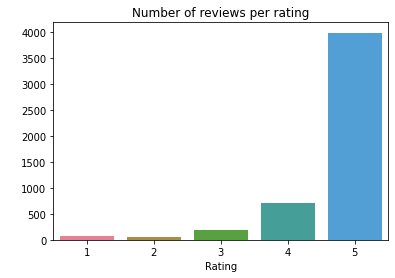

In [173]:
sns.countplot(x='review_rating', data=df_reviews)
plt.title('Number of reviews per rating')
plt.xlabel('Rating')
plt.ylabel(' ')
plt.show()

To overcome the skewness of our dataset we perform data augmentation. In order to achieve this we create new reviews with similar terms (according to the general word2vec pretrained model). 

In [39]:
#load pretrained model for augmentation
wv = api.load('word2vec-google-news-300')


[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [46]:
#corpus per rating
for i in range(1,6):
    exec(f'r{i} = df_reviews[df_reviews.loc[:,"review_rating"]==i]')
    exec(f"preprocessor = TextPreprocessor(r{i}, column_to_clean='review_content')")
    preprocessor.transform(n_grams=False)
    exec(f'corpus{i} = preprocessor.corpus')

In [42]:
def similar(corp):
    for i in range(len(corp)):
        print(i)                                      
        for j in range(len(corp[i])):
            n = randint(2)
            try:
                corp[i][j] = wv.most_similar(corp[i][j], topn=3)[n][0]
            except:
                continue
    return corp

In [ ]:
#we augment the number of reviews for ratings 1 and 2
corpus1_augmented = corpus1.copy()
corpus1_augmented = similar(corpus1_augmented)
corpus2_augmented = corpus2.copy()
corpus2_augmented = similar(corpus2_augmented)

In [49]:
#create a balanced datset
corpus_augmented = corpus1 + corpus1_augmented[1:36] + corpus2\
                   + corpus2_augmented + corpus3[:110] + corpus4[:110]\
                   + corpus5[:110]
ratings = [1]*104 + [2]*116 + [3]*110 + [4]*110 + [5]*110

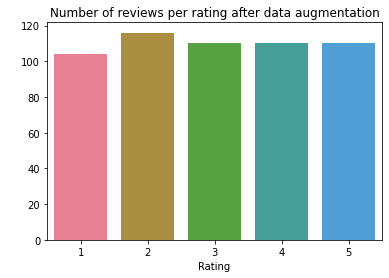

In [181]:
sns.countplot(x='rating', data=lsi)
plt.title('Number of reviews per rating after data augmentation')
plt.xlabel('Rating')
plt.ylabel(' ')
plt.show()

In [168]:
embeddor = Embeddor(corpus=corpus_augmented)
embeddor.transform(vec_method="tfidf", how="SVD", n="n_opt", threshold=0.5)
lsi = embeddor.review_embedding
lsi

145


,SV1,SV2,SV3,SV4,SV5,SV6,SV7,SV8,SV9,SV10,SV11,SV12,SV13,SV14,SV15,SV16,SV17,SV18,SV19,SV20,SV21,SV22,SV23,SV24,SV25,SV26,SV27,SV28,SV29,SV30,SV31,SV32,SV33,SV34,SV35,SV36,SV37,SV38,SV39,SV40,...,SV106,SV107,SV108,SV109,SV110,SV111,SV112,SV113,SV114,SV115,SV116,SV117,SV118,SV119,SV120,SV121,SV122,SV123,SV124,SV125,SV126,SV127,SV128,SV129,SV130,SV131,SV132,SV133,SV134,SV135,SV136,SV137,SV138,SV139,SV140,SV141,SV142,SV143,SV144,SV145
0,0.165283,0.033670,-0.118595,-0.003771,0.109350,0.088856,0.125202,-0.022432,-0.032250,-0.064915,0.019643,0.052732,0.093732,0.009170,0.070271,-0.003185,-0.128204,-0.020382,0.045134,-0.099441,0.007912,0.121025,0.077967,0.096494,-0.040195,-0.021219,-0.023769,0.059997,-0.097959,0.018944,0.024668,0.092812,0.009837,0.078474,-0.015660,-0.010755,0.034403,-0.021971,0.005125,0.006975,...,0.036468,0.021797,-0.063881,0.027300,0.017744,0.006758,0.038733,-0.012048,-0.019395,-0.013381,0.048767,0.053675,0.038358,0.033299,0.031467,-0.068150,0.008925,0.120852,0.016063,-0.065117,-0.008379,0.084741,-0.008554,0.011709,-0.072982,-0.027221,-0.019233,0.066887,0.033865,0.031131,-0.032248,-0.016033,-0.087787,0.000284,-0.016696,-0.029934,0.027806,-0.006777,-0.045457,0.041931
1,0.109286,-0.072756,-0.054281,-0.031846,-0.005371,-0.019668,-0.048488,0.064900,0.006551,0.030182,-0.005885,0.123735,-0.031437,-0.019562,-0.057971,0.019699,-0.034784,0.092186,0.055791,-0.023583,0.057230,-0.017343,0.017513,-0.041221,-0.019336,-0.008039,-0.022368,0.080245,-0.057296,-0.108305,0.035404,-0.033484,-0.013835,0.031343,0.038102,-0.001690,-0.017833,0.117544,0.029269,-0.029099,...,0.025686,0.019131,-0.018806,0.017459,-0.066932,-0.035078,0.009576,0.083084,-0.042402,0.007050,0.114112,-0.040903,-0.058238,-0.005827,0.105794,-0.045074,0.004879,0.082616,-0.007946,-0.066942,-0.013213,-0.008221,0.008149,-0.063781,0.050605,-0.088921,-0.020085,0.033530,0.036062,0.024142,-0.033638,-0.020262,0.011755,-0.016775,0.024190,-0.044266,0.039098,0.067128,-0.024950,0.061422
2,0.222286,-0.194860,-0.134200,0.015182,0.045560,-0.020229,-0.082654,-0.001557,-0.069302,0.094891,-0.060430,0.004923,0.038181,-0.010695,0.008653,0.076627,-0.063588,-0.073581,0.005585,-0.039865,-0.003724,0.005196,-0.035360,-0.106271,-0.034672,0.047564,-0.125450,0.052109,0.030927,-0.088971,-0.032699,0.032130,-0.009326,-0.042232,-0.027761,-0.062084,-0.078617,0.045193,0.028096,0.033794,...,-0.064565,0.041146,0.014533,-0.033874,-0.034059,0.045508,-0.010978,-0.016278,-0.000667,0.024196,0.033480,0.071164,-0.008230,-0.064820,-0.018741,0.023964,-0.100170,0.035650,-0.008337,-0.002395,0.029322,0.080048,-0.064622,-0.079467,0.021882,-0.012106,-0.099707,0.064948,0.019838,0.050994,0.018733,0.032073,-0.076353,0.030690,0.085250,0.002089,0.033001,0.000420,-0.010738,-0.036073
3,0.225558,-0.071891,0.065133,-0.140960,-0.021220,-0.187056,0.088303,-0.074873,-0.032783,-0.017016,0.000050,-0.005846,-0.126799,-0.037838,0.159851,-0.032772,-0.105688,-0.159707,0.051514,0.118349,0.031309,-0.069444,-0.083556,0.082878,-0.026961,0.074890,0.071025,0.003051,0.043605,0.013503,-0.125277,-0.112366,0.063994,0.005937,0.034458,0.027287,0.123114,-0.069595,0.056648,0.031224,...,-0.036726,-0.072958,-0.005346,0.044341,0.021789,0.026165,-0.026710,-0.081481,-0.046128,-0.057186,0.037153,0.003702,0.062291,0.066434,0.038145,0.005424,0.019421,0.006085,-0.084080,-0.019271,0.017607,0.004850,-0.072166,0.051127,-0.039513,-0.037608,0.005360,-0.020316,-0.011718,-0.030778,-0.025870,-0.002974,0.012421,-0.022382,-0.040236,0.030804,0.011422,-0.032252,-0.022508,0.022068
4,0.066623,-0.082402,-0.001546,-0.036616,-0.044661,-0.058361,0.048632,0.035670,-0.097025,-0.117896,0.091541,0.023392,0.180752,0.090601,0.043152,0.060255,-0.077425,0.025283,-0.054687,-0.040702,-0.123708,-0.217198,-0.015591,0.138958,-0.005806,0.022027,-0.016868,0.019101,-0.013620,0.123602,0.021234,-0.126008,-0.097607,-0.069156,0.132380,0.074396,-0.016427,-0.002270,0.189348,-0.014958,...,-0.002274,0.004695,-0.049548,-0.001644,-0.045608,-0.031189,0.016969,-0.038180,-0.037023,0.036997,0.029635,-0.049

In [169]:
embeddor = Embeddor(corpus=corpus_augmented)
embeddor.transform(vec_method="tfidf", how="SVD", n="n_opt", threshold=0.5)
lsi = embeddor.review_embedding
lsi['corpus'] = corpus_augmented
lsi['rating'] = ratings
lsi.head()

,SV1,SV2,SV3,SV4,SV5,SV6,SV7,SV8,SV9,SV10,SV11,SV12,SV13,SV14,SV15,SV16,SV17,SV18,SV19,SV20,SV21,SV22,SV23,SV24,SV25,SV26,SV27,SV28,SV29,SV30,SV31,SV32,SV33,SV34,SV35,SV36,SV37,SV38,SV39,SV40,...,SV108,SV109,SV110,SV111,SV112,SV113,SV114,SV115,SV116,SV117,SV118,SV119,SV120,SV121,SV122,SV123,SV124,SV125,SV126,SV127,SV128,SV129,SV130,SV131,SV132,SV133,SV134,SV135,SV136,SV137,SV138,SV139,SV140,SV141,SV142,SV143,SV144,SV145,corpus,rating
0,0.165283,0.033670,-0.118595,-0.003771,0.109350,0.088856,0.125202,-0.022432,-0.032250,-0.064915,0.019643,0.052732,0.093732,0.009170,0.070271,-0.003185,-0.128204,-0.020382,0.045134,-0.099441,0.007912,0.121025,0.077967,0.096494,-0.040195,-0.021219,-0.023769,0.059997,-0.097959,0.018944,0.024668,0.092812,0.009837,0.078474,-0.015660,-0.010755,0.034403,-0.021971,0.005125,0.006975,...,-0.063881,0.027300,0.017744,0.006758,0.038733,-0.012048,-0.019395,-0.013381,0.048767,0.053675,0.038358,0.033299,0.031467,-0.068150,0.008925,0.120852,0.016063,-0.065117,-0.008379,0.084741,-0.008554,0.011709,-0.072982,-0.027221,-0.019233,0.066887,0.033865,0.031131,-0.032248,-0.016033,-0.087787,0.000284,-0.016696,-0.029934,0.027806,-0.006777,-0.045457,0.041931,"[wanted, support, restaurants, 2nd, lockdown, ...",1
1,0.109286,-0.072756,-0.054281,-0.031846,-0.005371,-0.019668,-0.048488,0.064900,0.006551,0.030182,-0.005885,0.123735,-0.031437,-0.019562,-0.057971,0.019699,-0.034784,0.092186,0.055791,-0.023583,0.057230,-0.017343,0.017513,-0.041221,-0.019336,-0.008039,-0.022368,0.080245,-0.057296,-0.108305,0.035404,-0.033484,-0.013835,0.031343,0.038102,-0.001690,-0.017833,0.117544,0.029269,-0.029099,...,-0.018806,0.017459,-0.066932,-0.035078,0.009576,0.083084,-0.042402,0.007050,0.114112,-0.040903,-0.058238,-0.005827,0.105794,-0.045074,0.004879,0.082616,-0.007946,-0.066942,-0.013213,-0.008221,0.008149,-0.063781,0.050605,-0.088921,-0.020085,0.033530,0.036062,0.024142,-0.033638,-0.020262,0.011755,-0.016775,0.024190,-0.044266,0.039098,0.067128,-0.024950,0.061422,"[food, ok, nothing, special, nothing, complain...",1
2,0.222286,-0.194860,-0.134200,0.015182,0.045560,-0.020229,-0.082654,-0.001557,-0.069302,0.094891,-0.060430,0.004923,0.038181,-0.010695,0.008653,0.076627,-0.063588,-0.073581,0.005585,-0.039865,-0.003724,0.005196,-0.035360,-0.106271,-0.034672,0.047564,-0.125450,0.052109,0.030927,-0.088971,-0.032699,0.032130,-0.009326,-0.042232,-0.027761,-0.062084,-0.078617,0.045193,0.028096,0.033794,...,0.014533,-0.033874,-0.034059,0.045508,-0.010978,-0.016278,-0.000667,0.024196,0.033480,0.071164,-0.008230,-0.064820,-0.018741,0.023964,-0.100170,0.035650,-0.008337,-0.002395,0.029322,0.080048,-0.064622,-0.079467,0.021882,-0.012106,-0.099707,0.064948,0.019838,0.050994,0.018733,0.032073,-0.076353,0.030690,0.085250,0.002089,0.033001,0.000420,-0.010738,-0.036073,"[reserved, table, name, day, celebrations, arr...",1
3,0.225558,-0.071891,0.065133,-0.140960,-0.021220,-0.187056,0.088303,-0.074873,-0.032783,-0.017016,0.000050,-0.005846,-0.126799,-0.037838,0.159851,-0.032772,-0.105688,-0.159707,0.051514,0.118349,0.031309,-0.069444,-0.083556,0.082878,-0.026961,0.074890,0.071025,0.003051,0.043605,0.013503,-0.125277,-0.112366,0.063994,0.005937,0.034458,0.027287,0.123114,-0.069595,0.056648,0.031224,...,-0.005346,0.044341,0.021789,0.026165,-0.026710,-0.081481,-0.046128,-0.057186,0.037153,0.003702,0.062291,0.066434,0.038145,0.005424,0.019421,0.006085,-0.084080,-0.019271,0.017607,0.004850,-0.072166,0.051127,-0.039513,-0.037608,0.005360,-0.020316,-0.011718,-0.030778,-0.025870,-0.002974,0.012421,-0.022382,-0.040236,0.030804,0.011422,-0.032252,-0.022508,0.022068,"[reading, positive, reviews, really, excited, ...",1
4,0.066623,-0.082402,-0.001546,-0.036616,-0.044661,-0.058361,0.048632,0.035670,-0.097025,-0.117896,0.091541,0.023392,0.180752,0.090601,0.043152,0.060255,-0.077425,0.025283,-0.054687,-0.040702,-0.123708,-0.217198,-0.015591,0.138958,-0.005806,0.022027,-0.016868,0.019101,-0.013620,0.123602,0.021234,-0.126008,-0.097607,-0.069156,0.132380,0.074396,-0.016427,-0

Let's see how the different topics are linked to the quality of the reviews:

In [112]:
for i in range(145):
    rat_list = []
    lsi[f'SV{i+1}'] = np.abs(lsi[f'SV{i+1}'])
    top_words = lsi.sort_values(f'SV{i+1}', ascending=False).index[:20]
    print(f"Top words for topic {i} are : ")
    for ind in list(top_words):
        rat_list.append(ratings[ind])
    print(sum(rat_list)/20)

Average rating for topic 0 is : 4.5
Average rating for topic 1 is : 3.6
Average rating for topic 2 is : 3.55
Average rating for topic 3 is : 4.15
Average rating for topic 4 is : 3.95
Average rating for topic 5 is : 3.65
Average rating for topic 6 is : 3.55
Average rating for topic 7 is : 3.05
Average rating for topic 8 is : 3.65
Average rating for topic 9 is : 3.75
Average rating for topic 10 is : 3.55
Average rating for topic 11 is : 3.55
Average rating for topic 12 is : 3.65
Average rating for topic 13 is : 3.35
Average rating for topic 14 is : 3.9
Average rating for topic 15 is : 3.35
Average rating for topic 16 is : 3.8
Average rating for topic 17 is : 3.05
Average rating for topic 18 is : 3.55
Average rating for topic 19 is : 3.5
Average rating for topic 20 is : 2.95
Average rating for topic 21 is : 3.45
Average rating for topic 22 is : 3.5
Average rating for topic 23 is : 2.85
Average rating for topic 24 is : 4.1
Average rating for topic 25 is : 3.0
Average rating for topic 26 is

We can now visualize how the quality of a review is related to a topic. In the following example the topic 1 is mostly associated with good reviews while the second topic is mostly associated with bad reviews. 

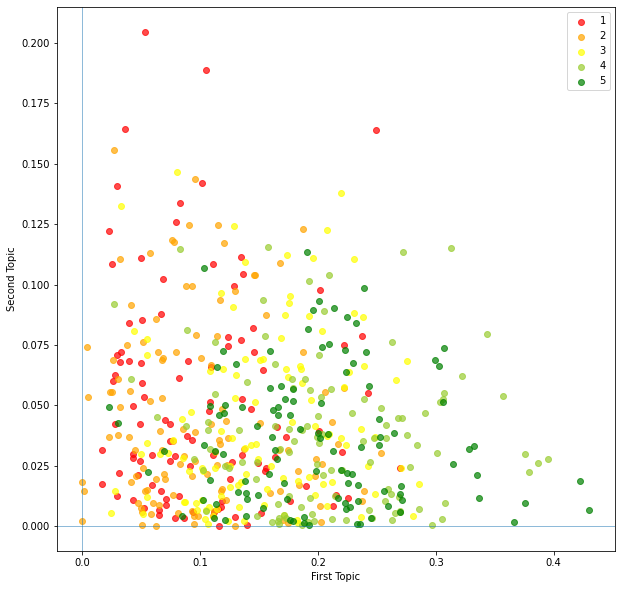

In [145]:
fig, ax = plt.subplots(figsize=(10,10))

colors = ['red', 'orange', 'yellow', 'yellowgreen', 'green']

for val in lsi['rating'].unique():
    topic_1 = np.abs(lsi[lsi['rating']==val]['SV1'].values)
    topic_2 = np.abs(lsi[lsi['rating']==val]['SV66'].values)
    color = colors[val-1]
    ax.scatter(topic_1, topic_2, alpha=0.7, label=val, color=color)
    
ax.set_xlabel('First Topic')
ax.set_ylabel('Second Topic')
ax.axvline(linewidth=0.5)
ax.axhline(linewidth=0.5)
ax.legend()

Let's see what are the top reviews associated with each topic. We observe that "food" is often mentioned in the reviews associated with the first topics while the service appears several times in the reviews associated with the second topic. We conclude that food is the differentiating factor for restaurants and bars while service is only a requirement. 


In [113]:
for i in [0, 65]:
    rat_list = []
    lsi[f'SV{i+1}'] = np.abs(lsi[f'SV{i+1}'])
    top_words = lsi.sort_values(f'SV{i+1}', ascending=False).index[:5]
    print(f"Top words for topic {i} are : ")
    for ind in list(top_words):
        print(lsi.corpus[ind])

Top reviews for topic 0 are :
['food', 'service', 'great']
['excellent', 'service', 'food', 'friendly', 'staff', 'food', 'delicious', 'arrived', 'quickly', 'would', 'definitely', 'recommend']
['long', 'time', 'since', 'restaurant', 'great', 'customer', 'service', 'staff', 'polite', 'great', 'sense', 'humour', 'food', 'expensive', 'quality', 'food', 'really', 'good', 'would', 'definitely', 'go']
['lovely', 'evening', 'good', 'food', 'wonderful', 'service', 'owner', 'staff', 'charming', 'italian', 'nice', 'atmosphere']
['visited', 'early', 'evening', 'saturday', 'friendly', 'greeting', 'attentive', 'service', 'restaurant', 'nice', 'ambience', 'food', 'tasty', 'service', 'good', 'return']
Top reviews for topic 65 are : 
['toured', 'oliveira', 'countless', 'occassions', 'find', 'foods', 'great', 'Inexpensive', 'although', 'gonna', 'out', 'Last', 'encounters']
['disappointed', 'food', 'disgusting', 'prices', 'comparible', 'ivy', 'unfortunately', 'near', 'quality', 'best', 'suggestion', 'rev

#Model

##LSI embedding

###Logistic regression

In [ ]:
from ast import literal_eval
path = '../balanced_corpus.txt'
with open(path, 'r') as f:
  corpus_augmented = literal_eval(f.read())

In [53]:
embeddor = Embeddor(corpus=corpus_augmented)
embeddor.transform(vec_method="tfidf", how="SVD", n="n_opt", threshold=0.5)
lsi = embeddor.review_embedding
lsi['rating'] = ratings
lsi

,SV1,SV2,SV3,SV4,SV5,SV6,SV7,SV8,SV9,SV10,SV11,SV12,SV13,SV14,SV15,SV16,SV17,SV18,SV19,SV20,SV21,SV22,SV23,SV24,SV25,SV26,SV27,SV28,SV29,SV30,SV31,SV32,SV33,SV34,SV35,SV36,SV37,SV38,SV39,SV40,...,SV107,SV108,SV109,SV110,SV111,SV112,SV113,SV114,SV115,SV116,SV117,SV118,SV119,SV120,SV121,SV122,SV123,SV124,SV125,SV126,SV127,SV128,SV129,SV130,SV131,SV132,SV133,SV134,SV135,SV136,SV137,SV138,SV139,SV140,SV141,SV142,SV143,SV144,SV145,rating
0,0.164573,0.030474,0.106980,-0.051205,0.122017,0.045497,0.127827,-0.035361,-0.061891,-0.077403,0.001841,0.058424,0.075710,0.032543,0.054127,-0.095447,-0.053102,0.012105,-0.000420,-0.071310,0.166330,-0.081051,0.008044,-0.031828,0.030374,0.054001,-0.069958,-0.007906,-0.060086,-0.054501,-0.065402,0.064403,0.078952,-0.097845,0.006603,-0.016656,0.020569,0.039010,0.016269,0.017363,...,-0.062630,0.032344,-0.038626,-0.026217,0.013131,0.040604,0.027868,-0.031481,-0.012554,0.010423,0.025254,0.027638,0.085335,0.053515,0.041876,-0.074594,-0.035862,0.001183,-0.075968,0.033596,-0.008622,-0.054242,0.035976,0.075541,-0.051374,-0.010593,-0.020328,0.023768,0.010268,-0.080646,0.054381,-0.015762,-0.012795,-0.034267,0.047810,-0.024181,-0.030046,-0.001609,-0.098997,1
1,0.108511,-0.073904,0.038364,-0.041746,-0.006370,-0.018115,-0.050287,0.064839,0.018836,0.020829,0.035842,0.119970,-0.015986,-0.047078,-0.057837,0.000679,-0.030073,0.100905,-0.029693,0.014633,-0.003772,-0.042816,-0.035280,0.048792,-0.040159,0.043982,-0.078013,0.058872,0.010865,-0.075717,-0.026220,0.032149,0.039478,0.026466,0.037153,0.052336,-0.002295,0.026578,-0.094854,-0.067415,...,0.009812,-0.039795,-0.070928,0.029703,0.029893,-0.038392,-0.159482,0.094002,0.018715,0.034003,0.035109,0.167678,0.067071,-0.019850,-0.031583,-0.012043,0.025928,0.065505,0.033254,-0.004879,0.044210,-0.059183,-0.056666,0.050190,0.016501,0.026109,0.003171,-0.064363,0.013228,-0.036292,-0.133676,-0.046089,-0.025428,0.146590,0.011844,-0.044086,0.082902,-0.017462,-0.154553,1
2,0.222860,-0.195894,0.123352,-0.018993,0.053707,-0.012455,-0.084111,0.003665,-0.046856,0.112920,-0.053920,0.019222,0.013424,-0.004048,0.019172,0.002334,-0.065225,-0.084528,-0.026602,-0.044604,0.010623,-0.037891,-0.070877,0.077729,-0.077315,-0.017664,-0.072313,-0.023411,0.133043,0.009717,-0.090525,-0.009632,-0.008907,0.011624,-0.045553,0.015067,-0.081886,-0.057665,-0.016727,-0.004508,...,0.041187,-0.005176,-0.001672,-0.036912,-0.004968,0.006691,-0.001294,0.021566,-0.009996,-0.056839,-0.014874,0.053466,-0.000872,-0.030739,0.124415,0.008793,0.028848,0.041228,-0.043390,-0.022008,-0.003827,-0.051838,-0.009328,-0.023628,0.006003,0.020247,0.069898,-0.021784,-0.009630,0.007148,0.011997,0.001262,-0.009352,-0.026657,0.061480,0.036322,-0.027024,0.008544,-0.017163,1
3,0.224990,-0.072014,-0.115452,-0.095462,-0.035965,-0.199945,0.062436,-0.057608,0.001000,0.015691,-0.000621,0.028893,-0.150995,0.068141,0.153145,-0.098595,-0.009041,-0.131564,-0.145289,0.075260,-0.024643,-0.026529,-0.058290,-0.133650,-0.044234,-0.057005,0.047247,0.015677,-0.039582,0.079351,0.003528,-0.061083,-0.151816,0.044420,0.068874,0.031217,0.150313,0.013992,0.055057,0.042358,...,-0.003151,0.101439,-0.016989,-0.061111,0.036730,0.027665,-0.003238,-0.039515,-0.132471,0.009905,-0.010912,0.033450,-0.009437,0.059976,0.058638,0.022609,-0.007128,0.000056,0.033540,0.066259,0.001156,0.017705,-0.036647,0.026660,0.013462,-0.051233,0.000040,0.005852,-0.054583,-0.020671,-0.052411,0.007411,-0.019766,0.057770,0.031975,-0.041163,-0.052373,0.026956,0.054291,1
4,0.066585,-0.081240,-0.010316,-0.028125,-0.046094,-0.076784,0.049681,0.030504,-0.118800,-0.114175,0.048685,0.012928,0.185727,0.069986,0.053268,0.014148,-0.175991,-0.039581,-0.033618,-0.091408,-0.173672,-0.087253,0.104580,-0.063469,0.018400,-0.057527,-0.046792,-0.063809,-0.140036,0.052057,0.129900,-0.095958,-0.019943,0.145175,-0.005676,0.033092,0.005260,-0.005293,-0.026575,0.118791,...,0.031168,0.027482,-0.023983,-0.009944,-0.052236,-0.002857,-0.017888,-0.006659,0.065419,-0.031017,0.009792,-0.026815,-0.002770,-0.060345,-

In [101]:
#prep df 
lsi.dropna(inplace=True)
X_train, X_test, y_train, y_test = train_test_split(lsi.iloc[:, :-1],
                                                    lsi.iloc[:, -1], 
                                                    test_size=0.2, 
                                                    random_state=0, 
                                                    shuffle=True)
# check distribution of ratings
print("Value counts for Train reviews")
print(y_train.value_counts())
print("Value counts for Test resviews")
print(y_test.value_counts())

Value counts for Train reviews
2    94
3    91
4    89
1    85
5    81
Name: rating, dtype: int64
Value counts for Test resviews
5    29
2    22
4    21
3    19
1    19
Name: rating, dtype: int64


In [77]:
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs')
logreg.fit(X_train, y_train)
# cross validation
scores_log = cross_val_score(logreg, X_train, y_train, cv = 10, 
                            scoring='f1_weighted')
print('Cross-validation scores:{}'.format(scores_log))
avg_score_log = np.mean(scores_log)
print('Average cross-validation score:{}'.format(avg_score_log))

Cross-validation scores:[0.5228355  0.68829942 0.59025974 0.45917155 0.55386413 0.54292929
 0.53106061 0.62877978 0.50385765 0.46027979]
Average cross-validation score:0.5481337455043234


In [78]:
#classification report 
pred_logreg = logreg.predict(X_test)
print(classification_report(y_test, pred_logreg))

              precision    recall  f1-score   support

           1       0.33      0.26      0.29        19
           2       0.36      0.45      0.40        22
           3       0.46      0.63      0.53        19
           4       0.44      0.33      0.38        21
           5       0.68      0.59      0.63        29

    accuracy                           0.46       110
   macro avg       0.45      0.45      0.45       110
weighted avg       0.47      0.46      0.46       110



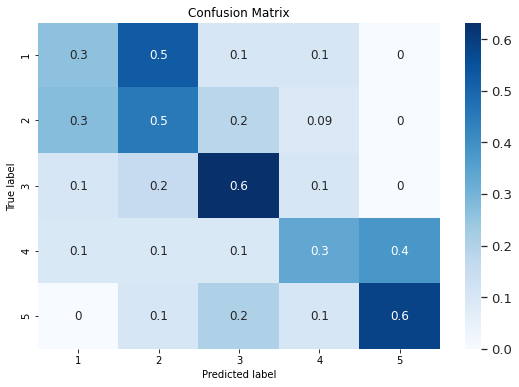

In [62]:
#confusion matrix
data = confusion_matrix(y_test, pred_logreg, normalize='true')
df_cm = pd.DataFrame(data, columns=[1, 2, 3, 4, 5], index=[1, 2, 3, 4, 5])
df_cm.index.name = 'True label'
df_cm.columns.name = 'Predicted label'
plt.figure(figsize = (9, 6))
plt.title('Confusion Matrix')
sns.set(font_scale=1.2) 
sns.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 12}, fmt='.1g')

###Random Forest

In [102]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

scores_rf = cross_val_score(rf, X_train, y_train, cv = 10, 
                            scoring='f1_weighted')
print('Cross-validation scores:{}'.format(scores_rf))
avg_score_rf = np.mean(scores_rf)
print('Average cross-validation score:{}'.format(avg_score_rf))

Cross-validation scores:[0.2735765  0.48329709 0.52431245 0.38546651 0.40587888 0.36250531
 0.4706885  0.60672269 0.41623377 0.44295826]
Average cross-validation score:0.43716399534081923


In [103]:
pred_labels_rf = rf.predict(X_test)
print(classification_report(y_test, pred_labels_rf))

              precision    recall  f1-score   support

           1       0.44      0.21      0.29        19
           2       0.38      0.41      0.39        22
           3       0.32      0.42      0.36        19
           4       0.42      0.62      0.50        21
           5       0.71      0.52      0.60        29

    accuracy                           0.45       110
   macro avg       0.45      0.44      0.43       110
weighted avg       0.48      0.45      0.44       110



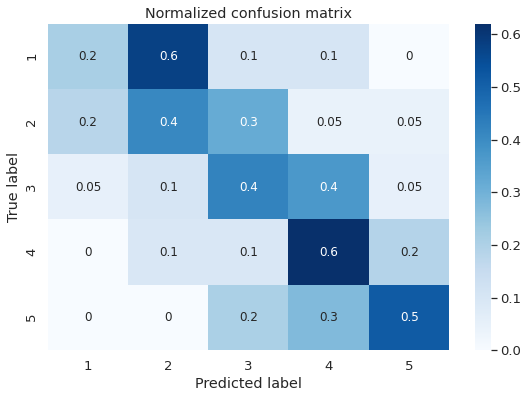

In [104]:
data = confusion_matrix(y_test, pred_labels_rf, normalize='true')
df_cm = pd.DataFrame(data, columns=[1, 2, 3, 4, 5], index=[1, 2, 3, 4, 5])

df_cm.index.name = 'True label'
df_cm.columns.name = 'Predicted label'
plt.figure(figsize = (9, 6))
plt.title('Normalized confusion matrix')
sns.set(font_scale=1.2) 
sns.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 12}, fmt='.1g'); 

The random forest classifier shows better result than the logistic regression classifier.

##Word2vec embedding

We use a random forest classifier with the word2vec embedding as input.

In [95]:
embeddor = Embeddor(corpus=corpus_augmented)
embeddor.transform(vec_method="word2vec", how="PCA", n=100) #n_opt wasn't offering good results
word2vec_embed = embeddor.review_embedding
word2vec_embed['rating'] = ratings
word2vec_embed

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


,Dimension_1,Dimension_2,Dimension_3,Dimension_4,Dimension_5,Dimension_6,Dimension_7,Dimension_8,Dimension_9,Dimension_10,Dimension_11,Dimension_12,Dimension_13,Dimension_14,Dimension_15,Dimension_16,Dimension_17,Dimension_18,Dimension_19,Dimension_20,Dimension_21,Dimension_22,Dimension_23,Dimension_24,Dimension_25,Dimension_26,Dimension_27,Dimension_28,Dimension_29,Dimension_30,Dimension_31,Dimension_32,Dimension_33,Dimension_34,Dimension_35,Dimension_36,Dimension_37,Dimension_38,Dimension_39,Dimension_40,...,Dimension_62,Dimension_63,Dimension_64,Dimension_65,Dimension_66,Dimension_67,Dimension_68,Dimension_69,Dimension_70,Dimension_71,Dimension_72,Dimension_73,Dimension_74,Dimension_75,Dimension_76,Dimension_77,Dimension_78,Dimension_79,Dimension_80,Dimension_81,Dimension_82,Dimension_83,Dimension_84,Dimension_85,Dimension_86,Dimension_87,Dimension_88,Dimension_89,Dimension_90,Dimension_91,Dimension_92,Dimension_93,Dimension_94,Dimension_95,Dimension_96,Dimension_97,Dimension_98,Dimension_99,Dimension_100,rating
0,12.633301,0.925321,-1.540961,0.763812,1.177710,0.831914,0.780878,-0.378187,0.277199,-0.534996,0.243374,-0.055232,0.312765,-0.012766,-0.080458,0.053366,-0.093348,0.311203,-0.072247,-0.115851,0.162040,0.203995,-0.082557,0.089523,-0.024892,-0.022001,0.091817,-0.131455,0.026895,0.084275,0.105123,-0.009543,-0.086345,-0.106290,-0.050206,-0.012411,0.033844,-0.080525,-0.146903,-0.050655,...,0.003488,0.033108,-0.042509,-0.034744,-0.120859,0.000701,-0.082276,0.006429,-0.003808,0.024957,-0.050715,-0.010696,-0.029739,-0.001776,-0.019449,0.006403,-0.016835,-0.018977,0.037029,-0.040313,-0.024981,0.015365,0.016363,-0.025672,0.014889,0.025448,0.004896,-0.002207,-0.013247,0.014849,0.022267,0.014516,0.021665,0.026471,0.015185,-0.036091,0.007214,-0.012712,0.003213,1
1,5.124018,-6.162241,0.449485,1.220973,-2.021786,2.470379,1.730122,0.403360,-1.155777,0.644081,-0.001885,0.005301,-0.018290,-0.387678,-0.260433,0.513274,0.067886,-0.057363,-0.187533,-0.136637,0.025586,-0.146044,0.152627,0.136875,-0.219358,-0.268218,-0.049883,0.215445,-0.264714,0.047282,-0.025721,0.091671,-0.035007,-0.196270,-0.101973,0.050270,0.240171,0.076263,-0.137637,-0.101541,...,0.019374,0.093011,0.002623,-0.055312,-0.028097,-0.056944,-0.041471,0.123104,-0.027120,-0.040815,-0.028678,0.049389,-0.081468,-0.079564,-0.023386,-0.101986,0.118058,-0.050076,-0.030336,0.025224,0.055830,0.012139,0.009810,-0.033719,-0.028873,0.003538,0.048978,0.062085,-0.014647,0.026550,0.023370,0.012445,-0.005020,-0.062266,-0.034339,-0.031590,-0.034765,0.006730,0.045863,1
2,-22.636131,-22.709291,2.625051,6.748605,-3.812131,13.769130,5.060905,-0.645892,-4.039266,0.929307,0.518392,-1.645889,1.129335,-0.738977,0.031993,-0.015561,0.493929,-0.316455,-0.162002,0.305652,0.117408,-0.611494,0.626035,0.400800,0.090137,-0.175024,-0.435438,0.322293,0.212402,0.036824,0.474678,0.077166,-0.392810,-0.414060,0.171465,-0.176749,0.077339,-0.389242,-0.160097,-0.145108,...,0.037081,-0.077423,-0.041722,-0.168980,0.139177,-0.090740,-0.088534,0.090577,-0.176245,-0.067162,0.069975,-0.128771,-0.139477,-0.068357,0.029806,-0.173864,0.113803,0.074511,0.011577,0.052875,0.108404,-0.029907,-0.060526,-0.049814,-0.074634,0.134293,0.053598,0.015972,-0.069094,0.041129,-0.115852,-0.098939,-0.061682,-0.047380,-0.033683,0.109543,-0.031835,-0.124493,0.030069,1
3,33.560861,1.076925,0.055632,2.308377,1.325221,-0.022845,0.708464,-0.918579,-0.600167,0.221609,0.254714,-0.702442,-0.399457,0.725606,-0.474104,-0.454231,-0.026640,-0.590646,0.002847,-0.192853,0.034756,0.156893,-0.090725,0.367217,0.246403,0.113290,0.076431,-0.096968,-0.223200,0.062088,-0.190854,0.023855,0.043030,0.024689,-0.072181,-0.004876,-0.178222,-0.091051,-0.007071,-0.171066,...,0.010665,0.021995,0.053833,0.059133,0.020574,0.016006,-0.010958,0.072215,-0.003349,-0.005825,0.025373,0.098713,0.001332,-0.047532,-0.006398,-0.038343,-0.082903,-0.007896,0.076025,-0.032375,-0.026234,0.023112,0.020129,-0.016752,-0.115544,0.035928,0.003952,0.034296,0.012681,0.041736,-0.015493,0.006

In [96]:
word2vec_embed.dropna(inplace=True)
X_train, X_test, y_train, y_test = train_test_split(word2vec_embed.iloc[:, :-1],
                                                    word2vec_embed.iloc[:, -1], 
                                                    test_size=0.2, 
                                                    random_state=0, 
                                                    shuffle=True)
# check distribution of ratings
print("Value counts for Train reviews")
print(y_train.value_counts())
print("Value counts for Test resviews")
print(y_test.value_counts())

Value counts for Train reviews
2    92
5    87
4    87
3    86
1    85
Name: rating, dtype: int64
Value counts for Test resviews
3    24
5    23
4    23
2    21
1    19
Name: rating, dtype: int64


In [97]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

scores_rf = cross_val_score(rf, X_train, y_train, cv = 10, 
                            scoring='f1_weighted')
print('Cross-validation scores:{}'.format(scores_rf))
avg_score_rf = np.mean(scores_rf)
print('Average cross-validation score:{}'.format(avg_score_rf))

Cross-validation scores:[0.42145136 0.53459596 0.34006867 0.45219318 0.47974549 0.46279773
 0.46089377 0.47206282 0.39973797 0.40935504]
Average cross-validation score:0.44329019764277466


In [98]:
#classification reports
pred_labels_rf = rf.predict(X_test)
print(classification_report(y_test, pred_labels_rf))

              precision    recall  f1-score   support

           1       0.28      0.26      0.27        19
           2       0.31      0.38      0.34        21
           3       0.44      0.33      0.38        24
           4       0.44      0.48      0.46        23
           5       0.52      0.52      0.52        23

    accuracy                           0.40       110
   macro avg       0.40      0.40      0.39       110
weighted avg       0.40      0.40      0.40       110



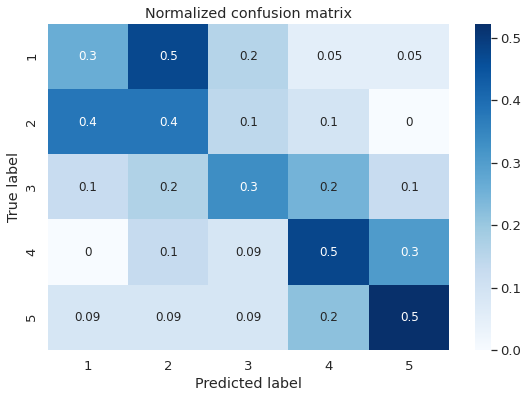

In [99]:
data = confusion_matrix(y_test, pred_labels_rf, normalize='true')
df_cm = pd.DataFrame(data, columns=[1, 2, 3, 4, 5], index=[1, 2, 3, 4, 5])

df_cm.index.name = 'True label'
df_cm.columns.name = 'Predicted label'
plt.figure(figsize = (9, 6))
plt.title('Normalized confusion matrix')
sns.set(font_scale=1.2) 
sns.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 12}, fmt='.1g'); 

##Fasttext Embedding

We use a random forest classifier with the fasstext embedding as input.

In [106]:
embeddor = Embeddor(corpus=corpus_augmented)
embeddor.transform(vec_method="fasttext", how="PCA", n=100) #n_opt wasn't offering good results
fasttext = embeddor.review_embedding
fasttext['rating'] = ratings
fasttext

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


,Dimension_1,Dimension_2,Dimension_3,Dimension_4,Dimension_5,Dimension_6,Dimension_7,Dimension_8,Dimension_9,Dimension_10,Dimension_11,Dimension_12,Dimension_13,Dimension_14,Dimension_15,Dimension_16,Dimension_17,Dimension_18,Dimension_19,Dimension_20,Dimension_21,Dimension_22,Dimension_23,Dimension_24,Dimension_25,Dimension_26,Dimension_27,Dimension_28,Dimension_29,Dimension_30,Dimension_31,Dimension_32,Dimension_33,Dimension_34,Dimension_35,Dimension_36,Dimension_37,Dimension_38,Dimension_39,Dimension_40,...,Dimension_62,Dimension_63,Dimension_64,Dimension_65,Dimension_66,Dimension_67,Dimension_68,Dimension_69,Dimension_70,Dimension_71,Dimension_72,Dimension_73,Dimension_74,Dimension_75,Dimension_76,Dimension_77,Dimension_78,Dimension_79,Dimension_80,Dimension_81,Dimension_82,Dimension_83,Dimension_84,Dimension_85,Dimension_86,Dimension_87,Dimension_88,Dimension_89,Dimension_90,Dimension_91,Dimension_92,Dimension_93,Dimension_94,Dimension_95,Dimension_96,Dimension_97,Dimension_98,Dimension_99,Dimension_100,rating
0,-4.340922,-3.063996,-0.864503,-0.589470,1.958692,-0.706859,0.286540,1.666909,-0.271879,2.349009,0.937293,2.790956,-1.762752,3.585908,-0.357117,0.615935,-1.754963,-0.914268,1.965287,-0.048620,1.259714,-0.975007,-0.647252,-1.341533,-2.337515,0.466940,-0.656053,1.035400,-0.278912,-0.771096,-2.273309,-0.531178,-0.828169,0.724192,0.245486,-0.363892,1.502506,0.148688,0.698897,0.012154,...,0.226563,0.159933,-0.353990,-0.034602,-0.483687,0.247306,-0.016684,-0.181611,0.045896,0.035928,0.007118,-0.314888,0.353964,0.083747,-0.019827,0.056905,0.009954,0.057964,0.012262,-0.177859,-0.081342,-0.015510,-0.125881,0.081456,0.092899,-0.018388,-0.202882,-0.226854,-0.091172,-0.162173,0.093935,-0.082818,-0.024234,-0.011898,0.253645,0.005072,0.045038,0.055900,0.061284,1
1,-4.834880,3.459258,7.965892,5.804991,-4.208906,1.484787,-0.184931,0.473346,-2.406454,-3.054322,1.040050,-5.163282,-4.688459,5.068439,-4.389635,6.059712,1.842526,0.930715,4.192934,2.537065,1.688649,-3.290195,-0.085588,3.865680,-1.079275,0.817050,-0.449168,2.521757,-1.144751,-0.556138,-0.313196,-1.996690,-1.114857,0.414630,0.227640,-1.310603,-0.232928,-1.724438,-1.674593,-3.037702,...,0.399338,0.172843,0.012589,-0.031239,-0.069845,1.368551,0.060901,0.127768,-0.535410,0.032417,0.284704,0.029795,-0.264654,-0.110454,0.382790,0.172765,-0.009039,0.392516,-0.126143,-0.087461,0.305241,-0.054977,0.448116,0.070082,-0.062008,0.030023,0.005929,0.062249,0.673420,0.140812,-0.083060,-0.146187,0.153275,-0.101266,0.210547,-0.212299,-0.164594,0.061050,0.055118,1
2,-13.961693,10.178485,40.080777,17.334623,3.795165,12.665862,9.694744,-10.376998,0.041121,-0.863690,4.969791,-8.802560,-0.842206,12.612384,-6.189723,-6.326248,16.723937,4.382124,12.017910,6.324362,3.727424,0.087964,4.584906,0.962644,-0.587860,2.442212,-0.424278,2.829888,-4.913557,-1.973330,-2.654276,0.708255,0.622977,-1.674696,3.501710,4.824626,-1.741882,3.105805,-3.998615,-1.239152,...,-1.050425,-0.859101,-0.505044,-0.135353,0.410560,0.444906,0.710074,-0.642864,-1.477603,0.081653,0.183539,-0.097394,-0.221996,0.826616,-0.353310,-0.990145,-0.827450,-0.053953,-0.367423,-1.031240,-0.419828,-0.701508,-0.240140,-0.432746,-0.109644,-0.312659,0.071606,0.515817,0.028587,0.222432,0.892224,-0.289209,-0.004336,0.341208,-0.259384,0.188180,0.335999,-0.376280,0.388001,1
3,-14.875946,-4.524866,-11.602745,-0.408790,-0.443563,1.087941,1.698899,-5.403525,9.342869,2.329488,-5.657603,0.814953,-1.361436,-3.249143,-0.018175,0.871598,-2.415636,2.365267,0.160299,-2.159030,-1.653929,2.311608,-1.629198,2.046284,-5.623369,-1.462459,2.089426,1.510304,0.975763,0.749715,0.234269,2.003692,1.918021,0.919993,1.786200,-0.104767,0.900741,0.245733,-1.082343,-0.265268,...,-1.177306,-0.477169,0.027827,0.044244,-0.120751,0.476830,-0.057522,0.143258,0.168898,0.043804,0.229629,0.212962,0.609469,0.429186,-0.152316,0.406048,-0.318257,0.370501,-0.102901,0.104445,-0.327157,0.169387,-0.014807,0.097824,0.474020,-0.310412,0.161591,0.237042,0.177265,0.155819,0.136418,-0.463078

In [107]:
fasttext.dropna(inplace=True)
X_train, X_test, y_train, y_test = train_test_split(fasttext.iloc[:, :-1],
                                                    fasttext.iloc[:, -1], 
                                                    test_size=0.2, 
                                                    random_state=0, 
                                                    shuffle=True)
# check distribution of ratings
print("Value counts for Train reviews")
print(y_train.value_counts())
print("Value counts for Test resviews")
print(y_test.value_counts())

Value counts for Train reviews
2    92
5    87
4    87
3    86
1    85
Name: rating, dtype: int64
Value counts for Test resviews
3    24
5    23
4    23
2    21
1    19
Name: rating, dtype: int64


In [109]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

scores_rf = cross_val_score(rf, X_train, y_train, cv = 10, 
                            scoring='f1_weighted')
print('Cross-validation scores:{}'.format(scores_rf))
avg_score_rf = np.mean(scores_rf)
print('Average cross-validation score:{}'.format(avg_score_rf))

Cross-validation scores:[0.5027071  0.41164743 0.3331954  0.40780829 0.43389992 0.39988964
 0.33873387 0.50348854 0.45138783 0.48328573]
Average cross-validation score:0.4266043752576957


In [110]:
#classification reports
pred_labels_rf = rf.predict(X_test)
print(classification_report(y_test, pred_labels_rf))

              precision    recall  f1-score   support

           1       0.22      0.21      0.22        19
           2       0.42      0.48      0.44        21
           3       0.46      0.50      0.48        24
           4       0.50      0.43      0.47        23
           5       0.59      0.57      0.58        23

    accuracy                           0.45       110
   macro avg       0.44      0.44      0.44       110
weighted avg       0.45      0.45      0.44       110



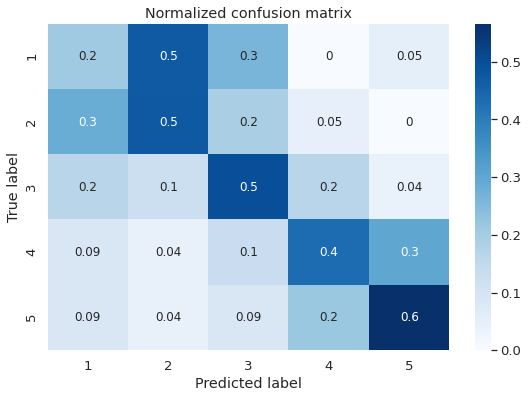

In [111]:
data = confusion_matrix(y_test, pred_labels_rf, normalize='true')
df_cm = pd.DataFrame(data, columns=[1, 2, 3, 4, 5], index=[1, 2, 3, 4, 5])

df_cm.index.name = 'True label'
df_cm.columns.name = 'Predicted label'
plt.figure(figsize = (9, 6))
plt.title('Normalized confusion matrix')
sns.set(font_scale=1.2) 
sns.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 12}, fmt='.1g'); 

#Final remark

None of our classifier is showing convincing results. However we are aware that several points can be improved: more data can be scrapped, data augmentation should be performed at a higher scale, a deep learning method could outperform the ones we have shown.

It is interesting to note that even if the dataset is balanced between the classes, it appears easier to predict accurately good reviews (rated 4 or 5) than negative ones (rated 1 or 2).